In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

In [ ]:

def _load_image(img_root: Path, file_name: str) -> Image.Image:
    path = img_root / file_name
    if not path.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    return Image.open(path).convert("RGB")


def _ann_to_binary_mask(ann, height, width) -> np.ndarray:
    """
    Returns HxW uint8 mask {0,1} for one annotation.
    Handles RLE (compressed/uncompressed) and polygons.
    """
    seg = ann.get("segmentation", None)
    if seg is None:
        return np.zeros((height, width), dtype=np.uint8)

    # Polygon format: list[list[xy...]] or list[xy...]
    if isinstance(seg, list):
        rles = mask_utils.frPyObjects(seg, height, width)
        rle = mask_utils.merge(rles)
        m = mask_utils.decode(rle)
        return (m > 0).astype(np.uint8)

    # RLE dict format
    if isinstance(seg, dict) and "counts" in seg and "size" in seg:
        rle = seg
        # Some installs require bytes
        if isinstance(rle["counts"], str):
            rle = dict(rle)
            rle["counts"] = rle["counts"].encode("ascii")
        m = mask_utils.decode(rle)
        return (m > 0).astype(np.uint8)

    return np.zeros((height, width), dtype=np.uint8)


def _alpha_blend(base_rgb: np.ndarray, mask: np.ndarray, color: np.ndarray, alpha: float) -> np.ndarray:
    """
    base_rgb: HxWx3 uint8
    mask: HxW {0,1}
    color: (3,) uint8
    alpha: float in [0,1]
    """
    out = base_rgb.astype(np.float32).copy()
    m = mask.astype(bool)
    out[m] = (1 - alpha) * out[m] + alpha * color.astype(np.float32)
    return np.clip(out, 0, 255).astype(np.uint8)


def _get_font(size=16):
    try:
        return ImageFont.truetype("DejaVuSans.ttf", size=size)
    except Exception:
        return ImageFont.load_default()


def _text_bbox(draw: ImageDraw.ImageDraw, text: str, font):
    """
    Robust text size computation across Pillow versions.
    Returns (w, h).
    """
    try:
        # Pillow >= 8
        x0, y0, x1, y1 = draw.textbbox((0, 0), text, font=font)
        return (x1 - x0, y1 - y0)
    except Exception:
        # Fallback for older Pillow
        return draw.textsize(text, font=font)

In [ ]:
def visualize_coco_overlays(
    coco_json,
    img_root,
    out_dir=None,
    limit=0,
    alpha=0.45,
    draw_box=False,
    seed=0,
    show=True,
    figsize=(12, 8),
    img_ids=None,
):
    """
    Visualize COCO instance segmentations as alpha-blended overlays.

    Parameters
    ----------
    coco_json : str or Path
        Path to COCO instances JSON.
    img_root : str or Path
        Directory containing images referenced by file_name.
    out_dir : str or Path or None
        If set, saves overlays to this directory (and optionally shows too).
    limit : int
        Max number of images (0 = all).
    alpha : float
        Mask overlay alpha in [0,1].
    draw_box : bool
        Draw bounding boxes.
    seed : int
        Random seed for deterministic colors.
    show : bool
        If True, displays inline with matplotlib.
    figsize : tuple
        Figure size for display.
    img_ids : list[int] or None
        If provided, only process these image IDs.

    Returns
    -------
    results : list[dict]
        Each entry has keys: img_id, file_name, pil_image (final), save_path (optional).
    """
    coco_path = Path(coco_json)
    img_root = Path(img_root)
    out_dir = Path(out_dir) if out_dir else None
    if out_dir:
        out_dir.mkdir(parents=True, exist_ok=True)

    coco = COCO(str(coco_path))

    # category_id -> name
    cats = coco.loadCats(coco.getCatIds())
    cat_id_to_name = {c["id"]: c["name"] for c in cats}

    # Decide which images
    if img_ids is None:
        img_ids = coco.getImgIds()
    if limit and limit > 0:
        img_ids = img_ids[:limit]

    font = _get_font(16)
    results = []

    for idx, img_id in enumerate(img_ids, start=1):
        img_info = coco.loadImgs([img_id])[0]
        pil_img = _load_image(img_root, img_info["file_name"])
        w, h = pil_img.size

        anns = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))

        base = np.array(pil_img, dtype=np.uint8)

        # Draw each instance onto base (overlay), then draw boxes/labels on top.
        for ann in anns:
            mask = _ann_to_binary_mask(ann, h, w)
            if mask.sum() == 0:
                continue

            # deterministic random color per annotation id
            rng2 = np.random.default_rng(int(ann["id"]) + int(seed) * 1000003)
            color = rng2.integers(low=0, high=256, size=(3,), dtype=np.uint8)
            base = _alpha_blend(base, mask, color, alpha)

        final = Image.fromarray(base)
        final_draw = ImageDraw.Draw(final)

        # Boxes + labels (draw after overlay so they stay readable)
        for ann in anns:
            bbox = ann.get("bbox", None)
            if not bbox:
                continue

            x, y, bw, bh = bbox
            x0, y0 = int(x), int(y)

            if draw_box:
                final_draw.rectangle([x, y, x + bw, y + bh], outline=(255, 255, 255), width=2)

            cat_name = cat_id_to_name.get(ann["category_id"], str(ann["category_id"]))
            text = f"{cat_name} #{ann['id']}"
            tw, th = _text_bbox(final_draw, text, font)
            pad = 2

            # Keep label inside image bounds
            y_top = max(0, y0 - th - 2 * pad)
            final_draw.rectangle([x0, y_top, x0 + tw + 2 * pad, y_top + th + 2 * pad], fill=(0, 0, 0))
            final_draw.text((x0 + pad, y_top + pad), text, fill=(255, 255, 255), font=font)

        save_path = None
        if out_dir:
            save_path = out_dir / f"{Path(img_info['file_name']).stem}_overlay.png"
            final.save(save_path)

        if show:
            plt.figure(figsize=figsize)
            plt.imshow(final)
            plt.axis("off")
            plt.title(f"[{idx}/{len(img_ids)}] image_id={img_id} file={img_info['file_name']}")
            plt.show()

        results.append(
            {
                "img_id": img_id,
                "file_name": img_info["file_name"],
                "pil_image": final,
                "save_path": str(save_path) if save_path else None,
            }
        )

    return results

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


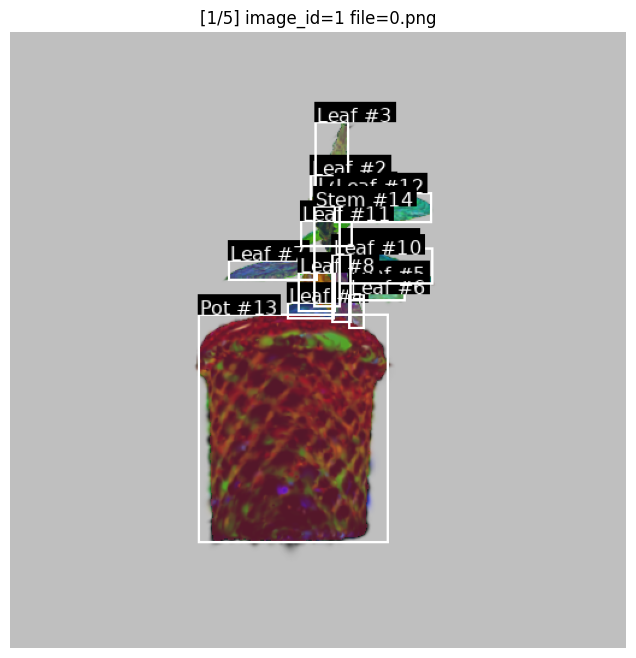

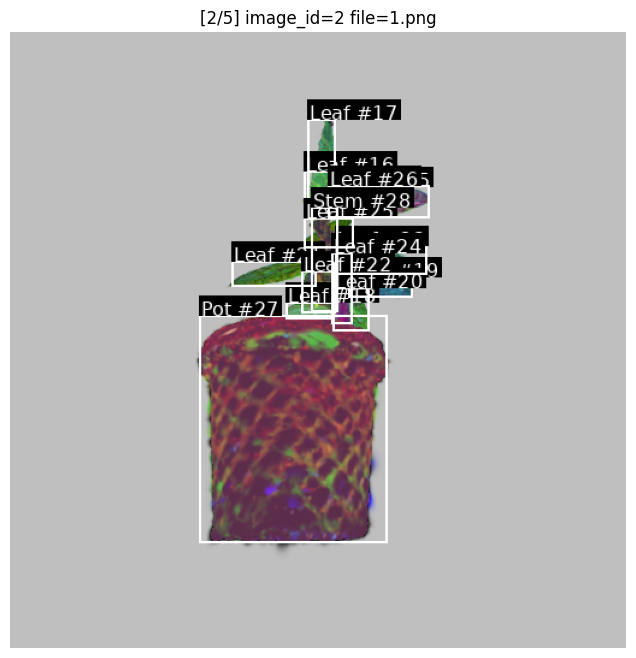

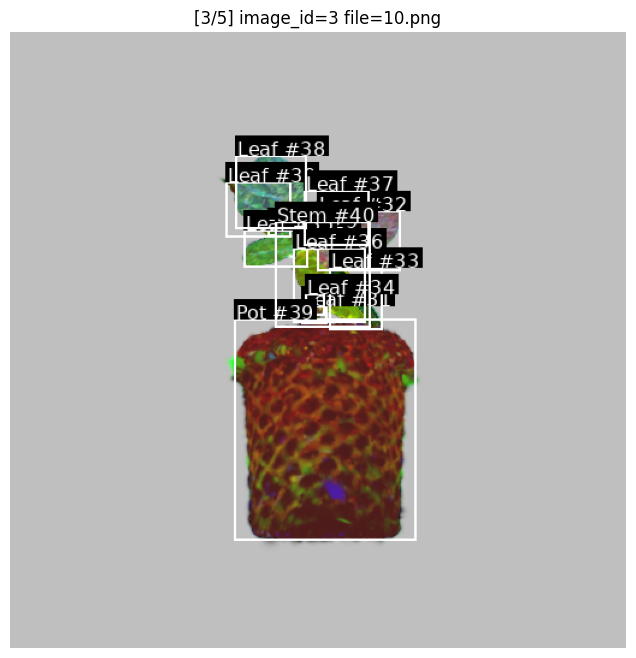

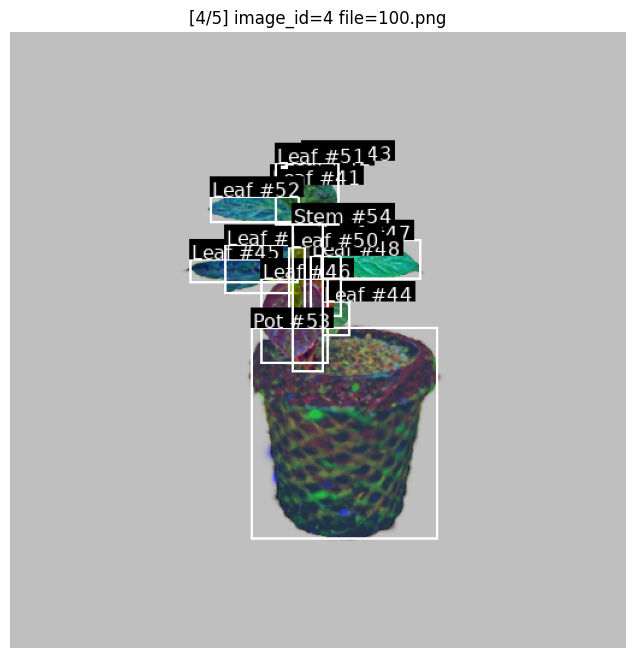

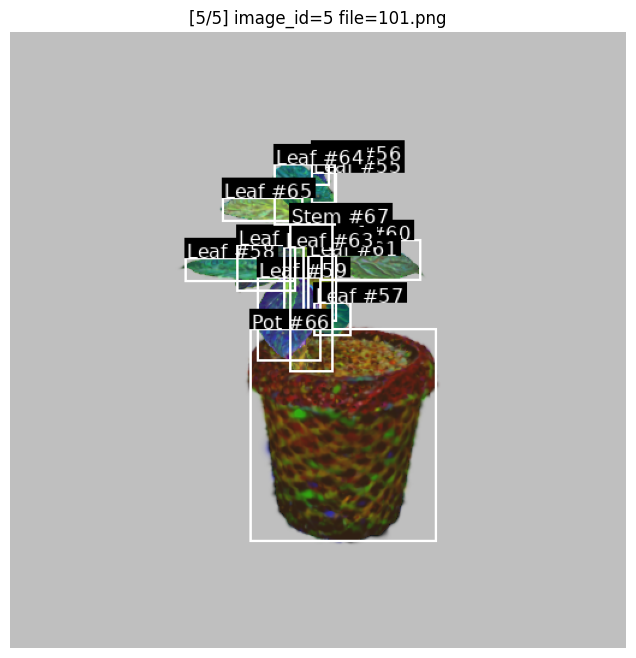

In [6]:
coco_json = "data/bean_instance_real/dataset/coco.json"
img_root = "data/bean_instance_real/dataset/gt"

_ = visualize_coco_overlays(
    coco_json=coco_json,
    img_root=img_root,
    limit=5,
    alpha=0.45,
    draw_box=True,
    seed=0,
    show=True,
)